# BDINF project SS2024

## Topic

The main goal is to check if there is a negative correlation between CO2 emissions and between the sum of new/used registered cars in AT (since 2000). It would be also good to know how the CO2 emission did reduce over time for newly registered cars as a percentage.

Members: Grégoire Bartek, Matthias Huber, David Berger

## Data Sources: 

Planned Data Source: It is planned to store the data in a MongoDB database. Emission data, new registered and used registered car data will be brouth to the same csv format and the loaded in into the mongodb database. We used data from data.gv.at, which are accessible for public usage.

AT new registered cars: https://www.data.gv.at/katalog/de/dataset/stat_pkw-neuzulassungen-nach-marken-ab-janner-2000#resources

AT used registered cars: https://www.data.gv.at/katalog/dataset/6fc1c927-bf21-3d72-9333-a9055493ab3c#additional-info

emission data: https://www.data.gv.at/katalog/dataset/bd462a04-2453-4c76-95bb-cfbd043540f5#resources . For the emission data it was important to use emission data only from passenger vehicles, since we get the registration data from normal "PKWs". The NFR emission category for passenger vehicles is 1A3b1

### MapReduce

In order to reduce the data from the csvs, we just parse the necessary information (Year and count/emission data) into separate csv which just have two columns: Year and data. For the car data we sum up the registered cars per month for a year to get a overall year value, which can later be easier compared and aggregated together


## Setup (TBD): 

MYSQL DB is running in a docker container, which will be versioned in the following Github repository (This is accomplished because we want to save Azure credits):

https://github.com/huhubi/BDINF_project

The queries will be made from this notebook, so the outcome is reproducable



### Versions used

- JupyterLab
- Python 3 as kernel

## Expected Output :

The data will be visualized and described in this notebook, it is expected to find a negative correlation between lower emissions and the production year of cars

# Documentation of procedure

First, we are downloading the csv data and doing explorative data analysis from AT emissions to check which categories are fitting for the car data. Since the data is from the years 1990-2022, and the car data is from 2000, just the emissions from 2000 are being considered. We then aggregated the data together, so it has the same formatting, to make the vizualization easier

In [1]:
import pandas as pd
!pip install openpyxl

data = pd.read_csv('emissions/schadstoffemissionen_1990-2022_nach_nfr_wide_1a3b1.csv', delimiter=';')
filtered_data = data[(data['NFR_Code'] == '1 A 3 b 1') & (data['Schadstoff'] == 'CO')]
print("Number of entries matching '1 A 3 b 1' and 'CO':", filtered_data.shape[0])

if filtered_data.shape[0] > 0:
    year_data = filtered_data.iloc[0]
    cleaned_data = pd.DataFrame([year_data])
    cleaned_data.to_excel('emissions/cleaned_co_emissions_1a3b1.xlsx', index=False)
    print("Excel file has been created with the required data.")
else:
    print("No data matches the specified filters.")

Number of entries matching '1 A 3 b 1' and 'CO': 1
Excel file has been created with the required data.


we need a little bit more cleanup

In [2]:
import pandas as pd

def clean_excel_data(input_path, output_path):
    data = pd.read_excel(input_path)
    
    year_columns = [col for col in data.columns if col.isdigit() and int(col) >= 1990]
    cleaned_data = data[year_columns]
    
    cleaned_data = cleaned_data.apply(lambda x: x.str.replace(',', '.').astype(float))
    
    cleaned_data.to_excel(output_path, index=False)

input_file_path = 'emissions/cleaned_co_emissions_1a3b1.xlsx'
output_file_path = 'emissions/cleaned_co_emissions.xlsx'

clean_excel_data(input_file_path, output_file_path)

now we can vizualize the data

the excel data has to be the same format as the csv data so we can make the vizualization, in order for that we need one more step

In [3]:
import pandas as pd

excel_path = 'emissions/cleaned_co_emissions.xlsx'
excel_data = pd.read_excel(excel_path)

excel_data_transposed = excel_data.transpose()

excel_data_transposed.reset_index(inplace=True)

excel_data_transposed.columns = ['Year', 'CO2 Emissions']

print(excel_data_transposed.head())

excel_data_transposed.to_csv('emissions/1a3b1.csv', index=False)


   Year  CO2 Emissions
0  1990     464.972529
1  1991     470.133014
2  1992     409.771877
3  1993     355.593462
4  1994     311.225494


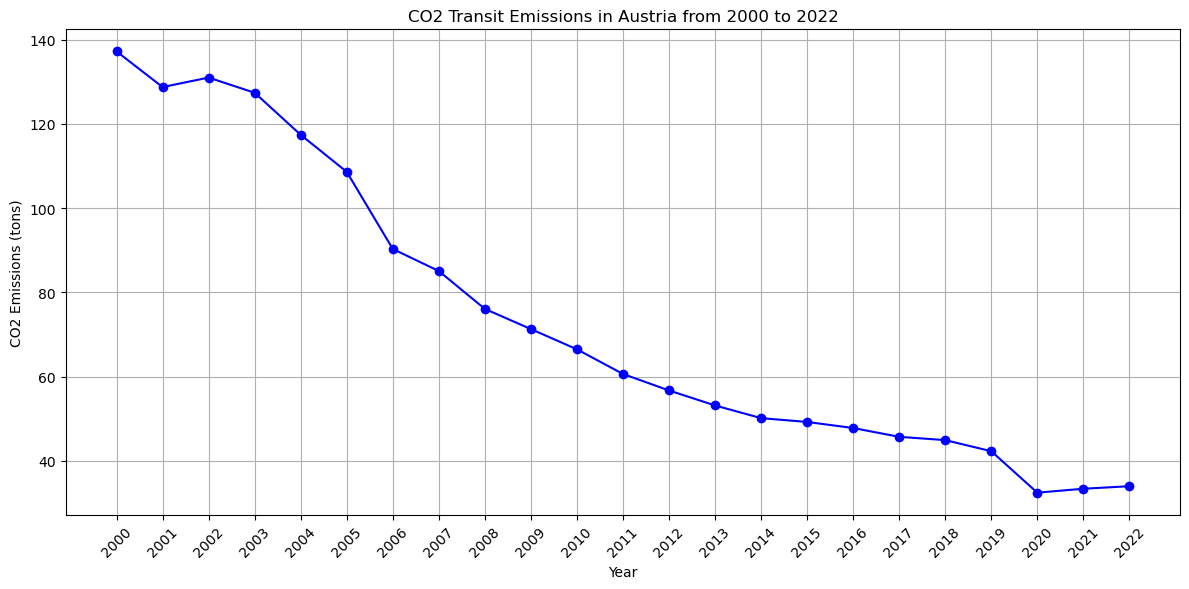

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

transformed_data_path = 'emissions/1a3b1.csv' 
transformed_data = pd.read_csv(transformed_data_path)

transformed_data['Year'] = transformed_data['Year'].astype(int)

filtered_data = transformed_data[(transformed_data['Year'] >= 2000) & (transformed_data['Year'] <= 2022)].copy()

filtered_data.loc[:, 'Year'] = filtered_data['Year'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Year'], filtered_data['CO2 Emissions'], marker='o', linestyle='-', color='blue')
plt.title('CO2 Transit Emissions in Austria from 2000 to 2022')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (tons)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

graph_path = 'results/austria_co2_emissions_2000_2022.png' 
plt.savefig(graph_path, format='png', dpi=300)  

plt.show()

# Explanation of new vehicle and used vehicle data

The column values of the overalldata.csv file have the following attributes:

C-J59-0 --> Passenger car names

C-A10-0 --> Time (monthly values)

C-EK7-0 --> vehicle type

F-ISIS-1 --> count


### New cars count per year and output of format

In [8]:
import pandas as pd

file_path = 'newcars/overalldata_new.csv' 
data = pd.read_csv(file_path)

data_split = data['C-J59-0;C-A10-0;C-EK7-0;F-ISIS-1'].str.split(';', expand=True)

data_split.columns = ['C-J59-0', 'C-A10-0', 'C-EK7-0', 'F-ISIS-1']

data_split['F-ISIS-1'] = pd.to_numeric(data_split['F-ISIS-1'])

data_split['Year'] = data_split['C-A10-0'].str.slice(4, 8).astype(int)

yearly_sum = data_split.groupby('Year')['F-ISIS-1'].sum().reset_index()

yearly_sum.columns = ['Year', 'Sum']

yearly_sum.to_csv('newcars/overalldata_yearly_sum_new.csv', index=False)

file_path_format_new_sum = 'newcars/overalldata_yearly_sum_new.csv'
data_new_sum = pd.read_csv(file_path_format_new_sum)
data_new_sum.head(), data_new_sum.columns


(   Year     Sum
 0  2000  309427
 1  2001  293528
 2  2002  279493
 3  2003  300121
 4  2004  311292,
 Index(['Year', 'Sum'], dtype='object'))

### let's check if the format of the generated csvs is the same

lets see how many new cars were registered from the timespan 2000-2022

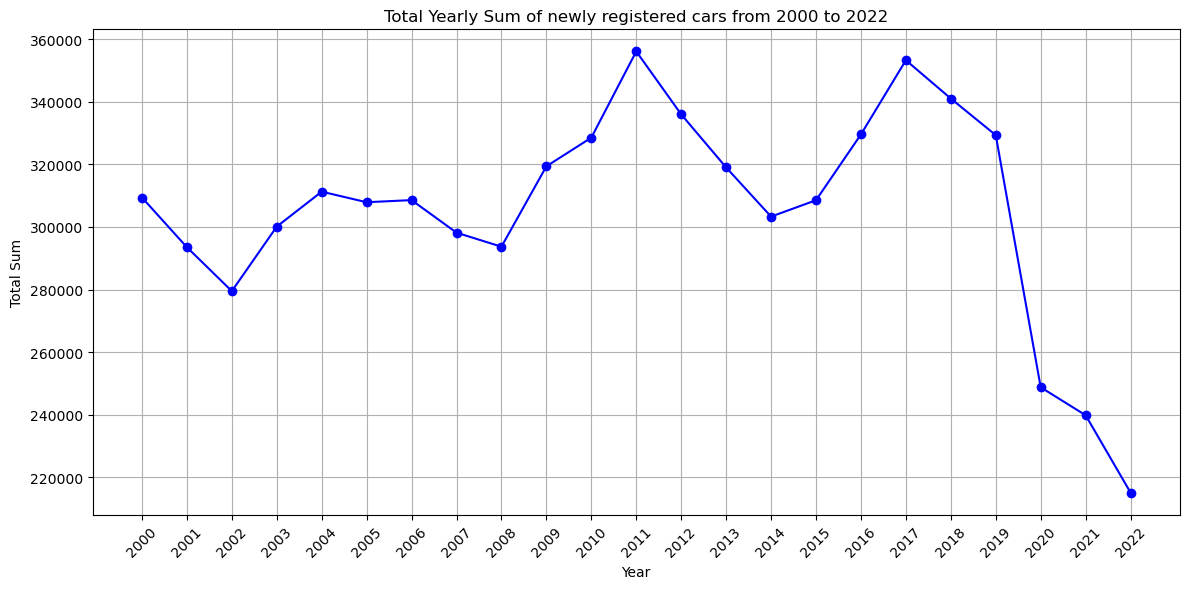

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the summed data from the CSV
data_path = 'newcars/overalldata_yearly_sum_new.csv'  # Adjust this path if the file is located elsewhere
yearly_sum = pd.read_csv(data_path)

# Filter the DataFrame to include only the years from 2000 to 2022
filtered_yearly_sum = yearly_sum[(yearly_sum['Year'] >= 2000) & (yearly_sum['Year'] <= 2022)]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(filtered_yearly_sum['Year'], filtered_yearly_sum['Sum'], marker='o', linestyle='-', color='blue')
plt.title('Total Yearly Sum of newly registered cars from 2000 to 2022')
plt.xlabel('Year')
plt.ylabel('Total Sum')
plt.grid(True)
plt.xticks(filtered_yearly_sum['Year'], rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

we see that the covid-19 pandemic had a slightly big influence on the registration of new cars

now we summarize the count of new cars with the emissions

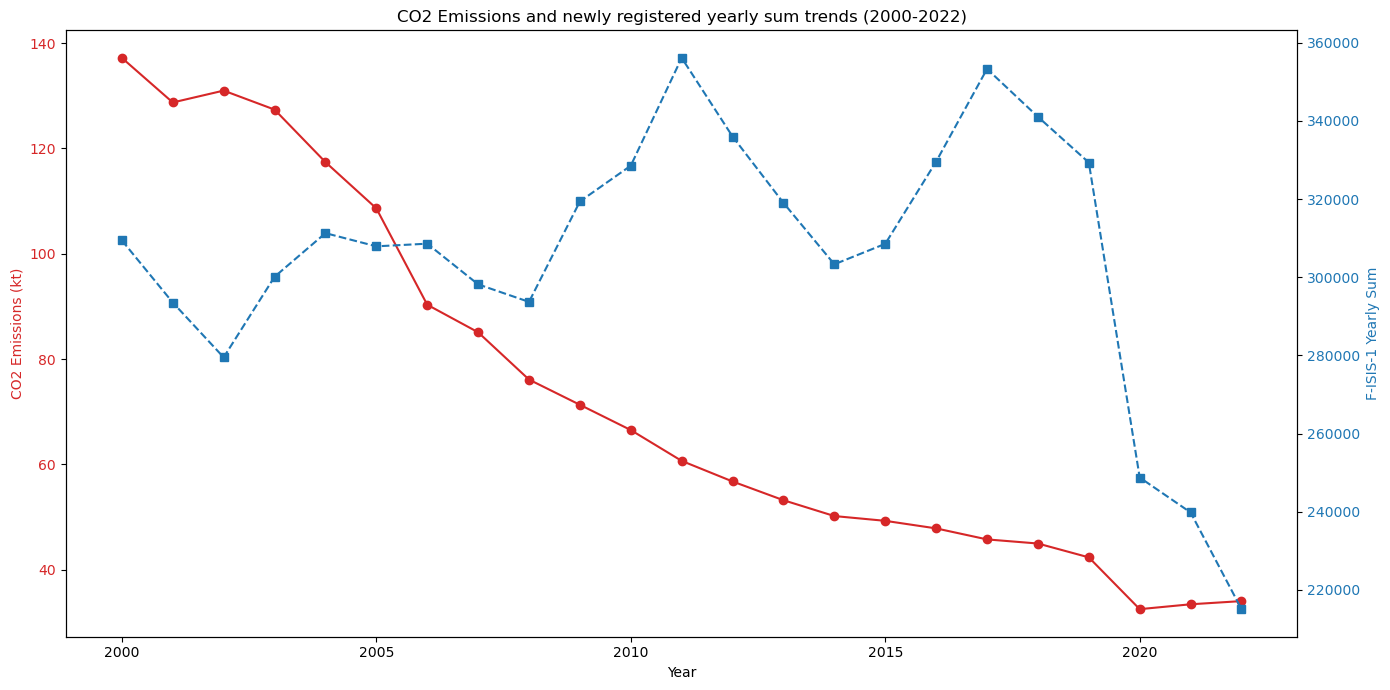

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the emissions data
emissions_data_path = 'emissions/1a3b1.csv'
emissions_data = pd.read_csv(emissions_data_path)

# Filter the emissions data for the years 2000 to 2022
emissions_data = emissions_data[(emissions_data['Year'] >= 2000) & (emissions_data['Year'] <= 2022)]

# Load the summed data from the F-ISIS-1
yearly_sum_data_path = 'newcars/overalldata_yearly_sum_new.csv'
yearly_sum_data = pd.read_csv(yearly_sum_data_path)

# Filter the yearly sum data for the years 2000 to 2022
yearly_sum_data = yearly_sum_data[(yearly_sum_data['Year'] >= 2000) & (yearly_sum_data['Year'] <= 2022)]

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Emissions data plot
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 Emissions (kt)', color=color)
ax1.plot(emissions_data['Year'], emissions_data['CO2 Emissions'], color=color, marker='o', linestyle='-', label='CO2 Emissions (kt)')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the yearly sum data
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('F-ISIS-1 Yearly Sum', color=color)
ax2.plot(yearly_sum_data['Year'], yearly_sum_data['Sum'], color=color, marker='s', linestyle='--', label='F-ISIS-1 Yearly Sum')
ax2.tick_params(axis='y', labelcolor=color)

# Title and other settings
plt.title('CO2 Emissions and newly registered yearly sum trends (2000-2022)')
fig.tight_layout()  # adjust subplot parameters to give specified padding

# Show the plot
plt.show()

# used car data 

In [11]:
import pandas as pd

file_path_used = 'usedcars/overalldata_used.csv'  
data_used = pd.read_csv(file_path_used)

data_split_used = data_used['C-J59-0;C-A10-0;C-EK7-0;F-ISIS-1'].str.split(';', expand=True)

data_split_used.columns = ['C-J59-0', 'C-A10-0', 'C-EK7-0', 'F-ISIS-1']

data_split_used['F-ISIS-1'] = pd.to_numeric(data_split_used['F-ISIS-1'])

data_split_used['Year'] = data_split_used['C-A10-0'].str.slice(4, 8).astype(int)

yearly_sum_used = data_split_used.groupby('Year')['F-ISIS-1'].sum().reset_index()

yearly_sum_used.columns = ['Year', 'Sum']

yearly_sum_used.to_csv('usedcars/overalldata_yearly_sum_used.csv', index=False)


In [12]:
file_path_usedcars = 'usedcars/overalldata_yearly_sum_used.csv'
data_usedcars = pd.read_csv(file_path_usedcars)
data_usedcars.head(), data_usedcars.columns

(   Year     Sum
 0  2000  750630
 1  2001  756630
 2  2002  747319
 3  2003  751276
 4  2004  776794,
 Index(['Year', 'Sum'], dtype='object'))

now we check the used car data with the emissions

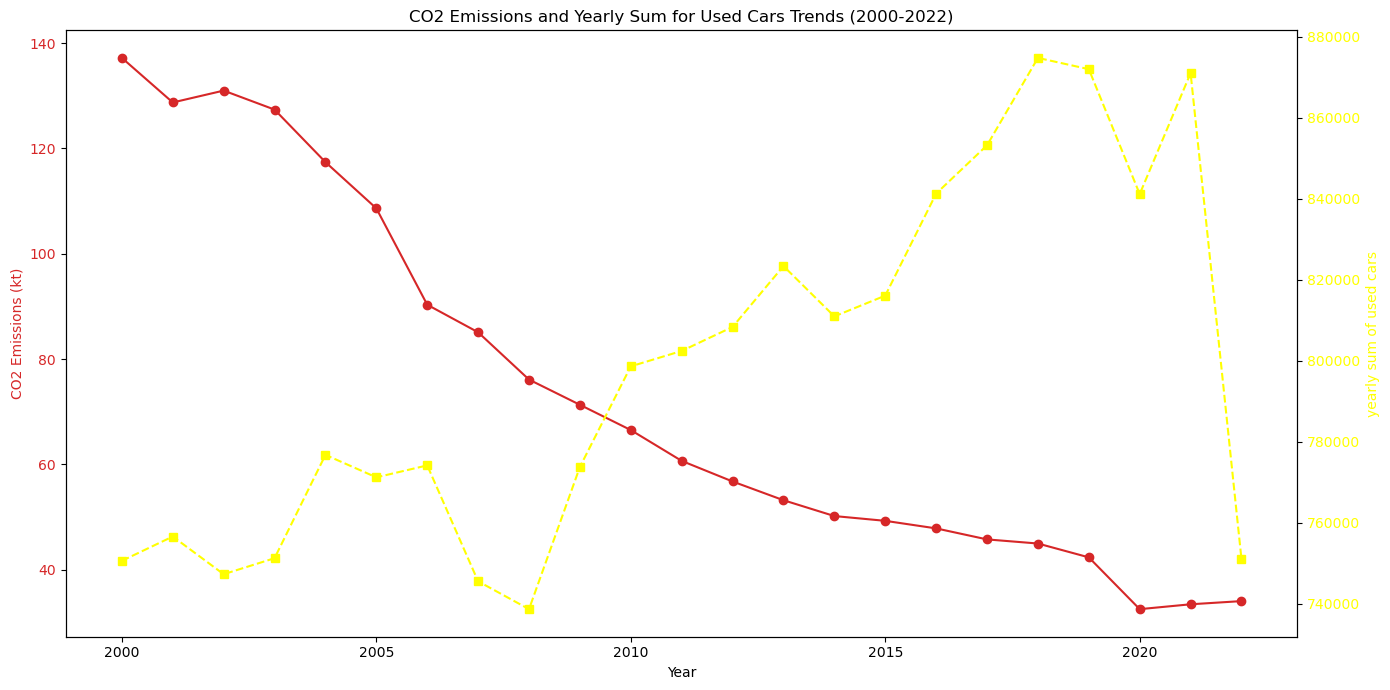

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

emissions_data_path = 'emissions/1a3b1.csv' 
emissions_data = pd.read_csv(emissions_data_path)

emissions_data = emissions_data[(emissions_data['Year'] >= 2000) & (emissions_data['Year'] <= 2022)]

yearly_sum_data_path_used = 'usedcars/overalldata_yearly_sum_used.csv' 
yearly_sum_data_used = pd.read_csv(yearly_sum_data_path_used)

yearly_sum_data_used = yearly_sum_data_used[(yearly_sum_data_used['Year'] >= 2000) & (yearly_sum_data_used['Year'] <= 2022)]

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 Emissions (kt)', color=color)
ax1.plot(emissions_data['Year'], emissions_data['CO2 Emissions'], color=color, marker='o', linestyle='-', label='CO2 Emissions (kt)')  # Convert to kilotonnes if needed
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'yellow'
ax2.set_ylabel('yearly sum of used cars', color=color)
ax2.plot(yearly_sum_data_used['Year'], yearly_sum_data_used['Sum'], color=color, marker='s', linestyle='--', label='yearly sum of used cars')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('CO2 Emissions and Yearly Sum for Used Cars Trends (2000-2022)')
fig.tight_layout()
plt.show()

# now to see if there is a correlation or not between the sum of used and newly registered cars and emission we need to sum up the table values

In [14]:
import pandas as pd

new_cars_data_path = 'newcars/overalldata_yearly_sum_new.csv'
new_cars_data = pd.read_csv(new_cars_data_path)

used_cars_data_path = 'usedcars/overalldata_yearly_sum_used.csv'
used_cars_data = pd.read_csv(used_cars_data_path)

combined_data = pd.merge(new_cars_data, used_cars_data, on='Year', suffixes=('_new', '_used'))

combined_data['Total Sum'] = combined_data['Sum_new'] + combined_data['Sum_used']

final_data = combined_data[['Year', 'Total Sum']]

print(final_data)

final_data.to_csv('results/final_combined_yearly_sum.csv', index=False)

    Year  Total Sum
0   2000    1060057
1   2001    1050158
2   2002    1026812
3   2003    1051397
4   2004    1088086
5   2005    1079157
6   2006    1082786
7   2007    1043748
8   2008    1032387
9   2009    1093212
10  2010    1127215
11  2011    1158603
12  2012    1144394
13  2013    1142452
14  2014    1114312
15  2015    1124671
16  2016    1170914
17  2017    1206564
18  2018    1215895
19  2019    1201406
20  2020    1089936
21  2021    1110868
22  2022     966061
23  2023     997131
24  2024     192233


Correlation Matrix:
                Total Sum  CO2 Emissions
Total Sum        1.00000       -0.49343
CO2 Emissions   -0.49343        1.00000


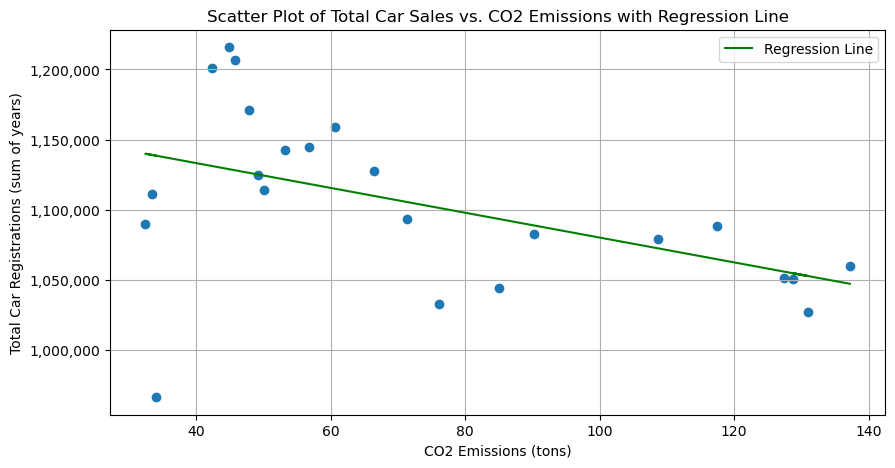

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

summed_data_path = 'results/final_combined_yearly_sum.csv'
summed_data = pd.read_csv(summed_data_path)
summed_data['Year'] = summed_data['Year'].astype(int)

emissions_data_path = 'emissions/1a3b1.csv'
emissions_data = pd.read_csv(emissions_data_path)
emissions_data = emissions_data[(emissions_data['Year'] >= 2000) & (emissions_data['Year'] <= 2022)]

combined_data = pd.merge(summed_data, emissions_data, on='Year', how='inner')

correlation = combined_data[['Total Sum', 'CO2 Emissions']].corr()
print("Correlation Matrix:\n", correlation)

plt.figure(figsize=(10, 5))
plt.scatter(combined_data['CO2 Emissions'], combined_data['Total Sum'])

slope, intercept = np.polyfit(combined_data['CO2 Emissions'], combined_data['Total Sum'], 1)
plt.plot(combined_data['CO2 Emissions'], slope*combined_data['CO2 Emissions'] + intercept, color='green', label='Regression Line')

plt.title('Scatter Plot of Total Car Sales vs. CO2 Emissions with Regression Line')
plt.xlabel('CO2 Emissions (tons)')
plt.ylabel('Total Car Registrations (sum of years)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.grid(True)
plt.legend()
plt.show()

combined_data.to_csv('results/combined_data_correlation.csv', index=False)

    A coefficient close to 1 indicates a strong positive correlation, meaning as one variable increases, the other also increases.
    A coefficient close to -1 indicates a strong negative correlation, meaning as one variable increases, the other decreases.
    A coefficient close to 0 suggests no linear correlation between the variables.

# Conclusion

We see that there is sa significant decrease of travel emissions of passenger cars, while the sum of overall registered cars did increase. It is also interesting to see that the COVID-19 pandemic lead to a decrease of emissions and registration of cars.